## This notebook will provide you with an introduction to the repository and assist you in getting your data set up

### 1. Setting up training data

Importantly, the programs in this repo assume a particular directory structure for the  training data. This is how it should be initialized:

Training Data \
-> Unprocessed \
-> Processed

**Place 'Training Data' in the same directory as this repository.** Make sure you add it to the .gitignore so you don't accidentally upload all the training data to GitHub. 

The directories should be empty at this point. To populate them, navigate to this link, https://docs.google.com/spreadsheets/d/13B823ukxdVMocowo1s5XnT3tzciOfruhUVePENKc01o/edit#gid=0 , and download the following track packs:
- Angevil Hero II
- Anti Hero
- Anti Hero 2
- Community Track Pack 6
- Digitizer
- Facelift Pack 1
- Facelift Pack 2
- Focal Point
- Guitar Hero X
- Paradigm

The track packs should be unzipped into the Unprocessed folder
> Training Data/Unprocessed

Once the track packs are unzipped, run the following cell to populate the processed folder, this might take a while.


In [1]:
# To process the training data, we will use the populated_processed_folder()
from pathlib import Path
import os
from tensor_hero.preprocessing.data import populate_processed_folder

unprocessed_path = Path.cwd() / 'Training Data' / 'Unprocessed'
processed_path = Path.cwd() / 'Training Data' / 'Processed'

assert (os.path.isdir(unprocessed_path) and os.path.isdir(processed_path)), 'ERROR: Place "Training Data" folder in this directory'

processing_data = populate_processed_folder(unprocessed_data_path=unprocessed_path,
                                            processed_data_path=processed_path)



AssertionError: ERROR: Place "Training Data" folder in this directory

### 2. tensor_hero module

I highly recommend parsing through each file in the tensor_hero module and reading through the functions and their docstrings.

The tensor_hero module is defined in the tensor_hero folder. It contains a suite of useful functions which you can import easily. Here's how that might work:

    from tensor_hero.preprocessing.data import populate_processed_folder

    <do something with populate_processed_folder>

If you wanted to see how populated_processed_folder() works, just navigate to
> ./tensor_hero/preprocessing/data.py

then read the docstring about populate_processed_folder()

Writing the line above will work in this jupyter notebook because its working directory contains the tensor_hero module, i.e. the folder structure is

tensor-hero *(this is the working directory)*\
-> tensor_hero *(this is the module)* \
-> \<other folders and scripts\> \
-> initialization.ipynb

If you wanted to use the tensor hero module in a directory other than the repo's home directory, you'll need to add the repo's home directory to the system's path explicitly. Let's say the folder structure was


tensor-hero \
-> tensor_hero *(this is the module)* \
-> \<other folders and scripts\> \
-> some_other_folder *(this is the working directory)*\
-----> initialization.ipynb

Now the working directory doesn't contain the tensor_hero module, so you need to add the top-level directory to your system path. This would look something like this.

    from pathlib import Path
    import sys
    sys.path.insert(1, str(Path.cwd().parent))
    from tensor_hero.visualization import slice_notes, plot_chart

or, in pseudocode

    import pathlib library, which makes it easy to work with filepaths
    import sys, which will be used to append to the system path
    append the directory outside of this one (Path.cwd().parent) to the system path
    import tensor_hero functions

Please be sure to use the pathlib library rather than hardcoding your own computer's filepath when doing these import statements

Now, let's see some of the things you can do with this module

#### Visualize the audio and notes of a song

In [2]:
# First, we load a song

from pathlib import Path
import os
from tensor_hero.visualization import plot_chart, slice_notes

song_dir = Path.cwd() / 'example_song'

print('Here are the files in the song directory:')
print(os.listdir(song_dir))

Here are the files in the song directory:
['album.png', 'notes.chart', 'notes.npy', 'notes_simplified.npy', 'separated.ogg', 'song.ini', 'song.ogg', 'spectrogram.npy']


- album.png -> album art
- notes.chart -> raw chart file
- notes.npy -> notes array
- notes_simplified.npy -> simplified notes array
- separated.ogg -> source separated audio file
- song.ini -> song metadata for Clone Hero use
- song.ogg -> raw audio file
- spectrogram.npy -> spectrogram from raw audio file

In [3]:
# Let's print a few lines of the .chart file to see which song we're dealing with

with open(song_dir / 'notes.chart', 'r', encoding="utf-8") as f:
    for idx, line in enumerate(f.readlines()):
        print(line)
        if idx > 5:
            break

[Song]

{

  Name = "Ouray"

  Artist = "Andy McKee"

  Charter = "Angevil"

  Album = "The Gates of Gnomeria"

  Year = ", 2007"



Spectrogram and notes have the same length in the time dimension:
spectrogram shape: (512, 13931)
notes shape: (13931,)


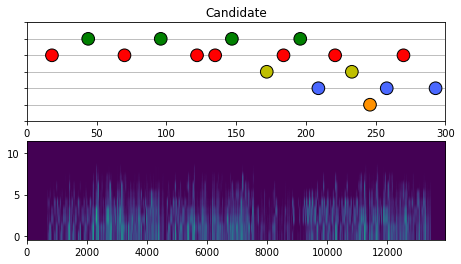

In [4]:
import numpy as np

# Okay it looks like we're going to be investigating the song Ouray.
# Let's plot a subsection of it's notes

# Load the spectrogram and notes
spec = np.load(song_dir / 'spectrogram.npy')
notes = np.load(song_dir / 'notes_simplified.npy')

print('Spectrogram and notes have the same length in the time dimension:')
print(f'spectrogram shape: {spec.shape}')
print(f'notes shape: {notes.shape}')

# plot_chart is useful for plotting spectrograms and printing guitar hero notes
_ = plot_chart(candidate=slice_notes(notes, 5, 8), audio=slice_notes(spec, 5, 8))


slice_notes() can be used on both notes arrays and audio.

What is the notes array though? Let's check it out.

raw notes array encompassing 3 seconds of song data:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0.]

Let's highlight just the ticks w

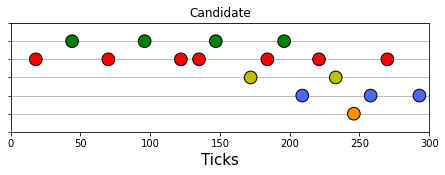

In [19]:
notes_section = slice_notes(notes, 5, 8)  # The notes array between seconds 5 and 8 of the song
print('raw notes array encompassing 3 seconds of song data:')
print(notes_section)

print('\nLet\'s highlight just the ticks with notes, only for the first 1 second of song data:')
print('tick : note')
for i, x in enumerate(list(notes_section)):
    if i > 100:
        break
    if x:
        print(f'{i} : {int(x)}')
        
print('\nYou could read this as: \nred note at 180ms \ngreen note at 440ms \nred note at 700ms \ngreen note at 960ms')
_ = plot_chart(candidate=notes_section)

In [ ]:
# Cool so now we kind of see what we're working with!